<b><font size=5>Анализ токсичных комментариев</font></b><a name="0."></a>

В нашем распоряжении набор данных с разметкой о токсичности правок. Перед нами стоит задача обучить модель классифицировать комментарии на позитивные и негативные.

<b><font size=5>Содержание</font></b><a name="to_content."></a>
* [Описание проекта](#0.)
* [Описание данных](#1.)
* [Задачи](#2.)
*  [Подготовка и исследование данных](#3.)
     - [Первичная предобработка](#3.1.)     
* [Обчение моделей](#4.) 
     - [Кодировка данных](#4.1.)
* [Общий вывод](#5.)

<b><font size=5>Описание данных</font></b><a name="1."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

* text - комментарий пользователя
* toxic - является ли комментарий токсичным  или нет (1 или 0)

<b><font size=5>Задачи</font></b><a name="2."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

1. Подготовить и исследовать данные
2. Обучить разные модели для классификации комментариев на позитивные и негативные.
3. Добиться значения метрики качества F1 не меньше 0.75
4. Общий вывод

<b><font size=5>Подготовка и исследование данных</font></b><a name="3."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression



In [2]:
df = pd.read_csv('C:/Users/User/toxic_comments.csv')

Посмотрим на наши данные

In [3]:
df.sample(10, random_state=42)

,text,toxic
119105,"Geez, are you forgetful! We've already discus...",0
131631,Carioca RFA \n\nThanks for your support on my ...,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0
111256,Pseudoscience category? \n\nI'm assuming that ...,0
83590,"(and if such phrase exists, it would be provid...",0
37546,", 9 October 2007 (UTC)\n\nP.s, the delta funct...",0
98371,"]]- 10 September 1910, [[[Couvet]] )",0
67118,Negro league baseball task-force talk].,0
129625,List of My Three Sons episodes \n\nI saw you r...,0
48941,Quoting Loremaster: In order to make sure you ...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Видим, что в нашем датасете около 150 000+ строк. Посмотрим на распределение целевого признака. 

<b><font size=4>Первичная предобработка данных</font></b><a name="3.1."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

(-1.25, 1.25, -1.25, 1.25)

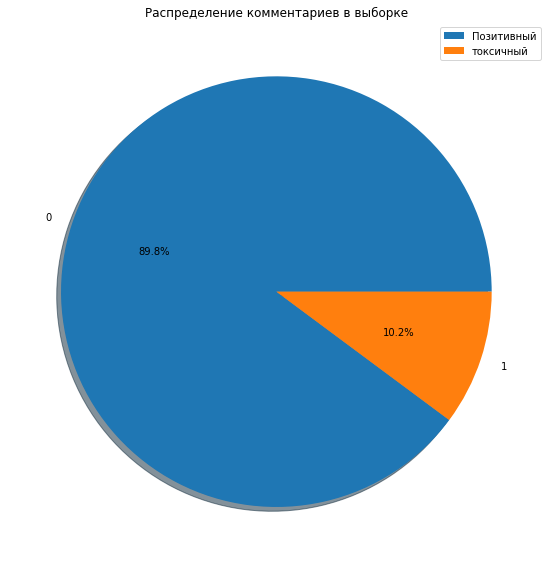

In [5]:
df.toxic.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(10,8))
plt.legend(['Позитивный','токсичный'])
plt.title('Распределение комментариев в выборке')
plt.tight_layout()
plt.axis('off')

Видим, что у нас дисбаланс выборки. Позитивных комментариев больше, чем токсичных. Так же помним, что комментарии были выгружены с какими-то спец.символами и числами. Очистим их с помощью регулярных выражений и лемматизируем

In [6]:
def clean_symbols(text):
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    return text.strip().lower()

In [7]:
df['text'] = df['text'].apply(clean_symbols)

In [8]:
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer()
def lemmatize(text, m=wnl):
    word_list = tknzr.tokenize(text)
    return ' '.join([wnl.lemmatize(w) for w in word_list])

In [9]:
df['text'] = df['text'].apply(lemmatize)

Пристуим к обучению моделей.

<b><font size=5>Обучение моделей</font></b><a name="4."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

<b><font size=4>Кодировка данных </font></b><a name="4.1"></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['toxic'],
                                                    test_size=0.2, random_state=42, stratify=df.toxic)

In [11]:
train_corpus = X_train.astype('U')
corpus_test = X_test.astype('U')

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
tfv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))

In [14]:
X_vector_train = tfv.fit_transform(train_corpus)
X_vector_test = tfv.transform(corpus_test)

In [15]:
model_lr =LogisticRegression(random_state=42)
model_sgd = SGDClassifier(random_state=42)

params_lr = {
          'class_weight':['balanced'],
          'C':[3],
          'max_iter':[500]}        

params_sgd = {
        'class_weight':['balanced', None],
        'max_iter':[500,1000],
        'loss':['log','squared_hinge'],
        'shuffle':[True],
        'penalty':['l1'],
        'n_iter_no_change':[20,30]}

In [16]:
grid_lr = GridSearchCV(model_lr, param_grid=params_lr, scoring='f1',verbose=3, cv=5, n_jobs=-1)

In [17]:
grid_lr.fit(X_vector_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3], 'class_weight': ['balanced'],
                         'max_iter': [500]},
             scoring='f1', verbose=3)

In [18]:
grid_lr.best_score_

0.7761820610066421

In [19]:
grid_lr.best_params_

{'C': 3, 'class_weight': 'balanced', 'max_iter': 500}

In [20]:
grid_sgd = GridSearchCV(model_sgd, param_grid=params_sgd, scoring='f1',verbose=3, cv=5, n_jobs=-1)

In [21]:
grid_sgd.fit(X_vector_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'loss': ['log', 'squared_hinge'],
                         'max_iter': [500, 1000], 'n_iter_no_change': [20, 30],
                         'penalty': ['l1'], 'shuffle': [True]},
             scoring='f1', verbose=3)

In [22]:
grid_sgd.best_score_

0.6999889709430409

In [23]:
grid_sgd.best_params_

{'class_weight': 'balanced',
 'loss': 'log',
 'max_iter': 500,
 'n_iter_no_change': 30,
 'penalty': 'l1',
 'shuffle': True}

Итак, видим, что наилучшие показатели у логистической регрессии. Проверим на тесте.

In [24]:
pred = grid_lr.predict(X_vector_test)

In [25]:
f1_score(y_test, pred)

0.7675223536198441

In [26]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28226
           1       0.82      0.72      0.77      3689

    accuracy                           0.95     31915
   macro avg       0.89      0.85      0.87     31915
weighted avg       0.95      0.95      0.95     31915



Text(0.5, 1.05, 'Матрица ошибок')

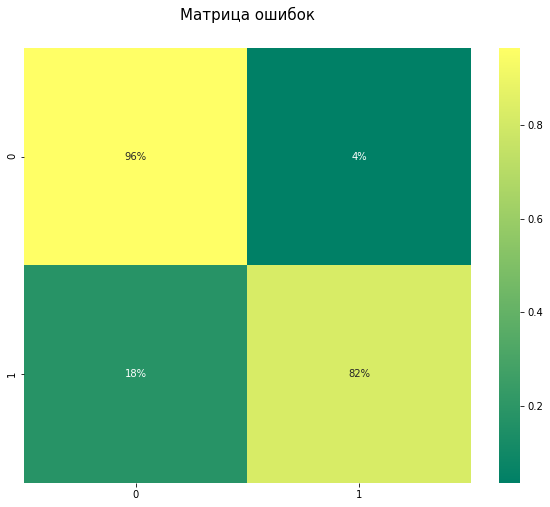

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, pred, normalize='true'),annot=True,fmt='.0%',cmap="summer")
plt.title('Матрица ошибок', y=1.05, size=15)

Видим, что логистическая регрессия лучше справляется с поставленной задачей, хоть и время обучения занимает чуть дольше. Процент False Positive и False Negative различается, но удовлетворяет требования

<b><font size=5>Вывод</font></b><a name="5."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Итак, можно сделать вывод, что исходя из данных лучше всего с предсказанием токсичных комментариев справиласть модель логистической регрессии. Что нам показывает как F1 оценка, так и матрица ошибок. Цель достигнута, модель обучена.